<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
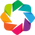

In [1]:
from neo4j import GraphDatabase
import nxneo4j as nxn
import json
import re
import networkx as nx
from networkx.readwrite import json_graph
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import ipywidgets as widgets
import holoviews as hv
hv.extension('bokeh')
from holoviews import opts
import numpy as np
import seaborn as sns

In [2]:
uri = "neo4j+s://my-uri.databases.neo4j.io"
user = "neo4j"
password = "my-pass"
driver = GraphDatabase.driver(uri, auth=(user, password))

In [3]:
G = nxn.Graph(driver) # or nx.DiGraph(driver) for directed graphs

In [35]:
with open("./MC3_schema.json") as f:
    schema = json.load(f)

with open("./MC3_graph.json") as g:
    graph_data = json.load(g)

G_nx = json_graph.node_link_graph(graph_data)

C:\Users\lupia\Documents\virtualenvs\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:287: FutureWarning:


The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.



In [5]:
def format_dict(d):
    parts = []
    for k, v in d.items():
        key_str = str(k)
        if v is None:
            v = " "
        if isinstance(v, str):
            v = v.replace("'", "")
            val_str = f"'{v}'"
        elif isinstance(v, datetime):
            val_str = f"'{v.isoformat()}'"  # format datetime as ISO string
        else:
            val_str = str(v)
        parts.append(f"{key_str}: {val_str}")
    return "{" + ", ".join(parts) + "}"

### Solo ejecutar una vez. Las subsiguientes veces no será necesario

In [6]:
#G.delete_all()

In [7]:
for node_id, attrs in G_nx.nodes(data=True):
    node_id = re.sub(r'[^a-zA-Z0-9]', '_', node_id)
    sub_type = attrs.get("sub_type")
    label = re.sub(r'[^a-zA-Z0-9]', '_', attrs.get("label"))
    attrs["id"] = node_id
    attrs.pop('sub_type', None)
    attrs.pop('type', None)
    formatted = format_dict(attrs)
    query = "CREATE (n:{} {})".format(sub_type, formatted)
    try:
        driver.execute_query(query)
    except Exception as e:
        print(query)

In [10]:
for source, target, attrs in G_nx.edges(data=True):
    source = re.sub(r'[^a-zA-Z0-9]', '_', source)
    target = re.sub(r'[^a-zA-Z0-9]', '_', target)
    if attrs.get("type") is None:
        relationship_type = "CONNECTED"
    else:
        relationship_type = attrs.get("type").upper()

    formatted_attrs = format_dict(attrs)
    query = f"""
        MATCH (a {{id: '{source}'}})
        MATCH (b {{id: '{target}'}})
        CREATE (a)-[r:{relationship_type} {formatted_attrs}]->(b)
    """
    try:
        driver.execute_query(query)
    except Exception as e:
        print(query)

#### Prueba

In [6]:
data=driver.execute_query("""
                     MATCH (n1)-[r1:SENT]->(n2), 
                     (n2)-[r2:RECEIVED]->(n3)
                     WHERE n1.name='Mako'
                    RETURN n1, n2, n3, r1, r2;
                    """)

In [7]:
records = []
for record in data.records:
    n1 = record.data()["n1"]
    n2 = record.data()["n2"]
    n3 = record.data()["n3"]
    r1 = record.data()["r1"]
    r2 = record.data()["r2"]

    records.append({
        'sender': n1['name'],
        'message_id': n2['id'],
        'content': n2['content'],
        'timestamp': n2['timestamp'],
        'receiver': n3['name'] if 'name' in n3 else n3['label'],
    })

df_Mako = pd.DataFrame(records)
df_Mako['timestamp'] = pd.to_datetime(df_Mako['timestamp'])  # Asegura que sea datetime

In [8]:
df_Mako

,sender,message_id,content,timestamp,receiver
0,Mako,Event_Communication_15,"Serenity, this is Mako. For premium diving com...",2040-10-01 08:52:00,Serenity
1,Mako,Event_Communication_59,Mako to Remora. Hows visibility in your sector...,2040-10-01 11:10:00,Remora
2,Mako,Event_Communication_99,"Himark Harbor, this is Mako. Well remain docke...",2040-10-02 08:54:00,Himark Harbor
3,Mako,Event_Communication_117,Mako to Sailor Shifts Team. Vessel remains doc...,2040-10-02 11:04:00,Sailor Shifts Team
4,Mako,Event_Communication_123,"Marlin, Mako here. The new licensing costs are...",2040-10-02 12:09:00,Marlin
5,Mako,Event_Communication_139,"Osprey, this is Mako. Received your charter re...",2040-10-02 12:46:00,Osprey
6,Mako,Event_Communication_145,"Himark Harbor, this is Mako. Confirming extend...",2040-10-02 12:56:00,Himark Harbor
7,Mako,Event_Communication_254,"Reef Guardian, this is Mako. Confirming positi...",2040-10-04 08:38:00,Reef Guardian
8,Mako,Event_Communication_268,"Sentinel, this is Mako. Transponder malfunctio...",2040-10-04 09:15:00,Sentinel
9,Mako,Event_Communication_309,"Oceanus Council, Mako responding. Currently op...",2040-10-04 13:31:00,Oceanus City Council


In [9]:
df_Mako['date'] = df_Mako['timestamp'].dt.date

hv_plot = hv.Curve(df_Mako.groupby('date').size().reset_index(name='count')).opts(
    xlabel='Fecha', ylabel='N° de Mensajes',
    title='Mensajes enviados por día',
    width=600, height=300, color='navy'
)
hv_plot

:Curve   [date]   (count)

In [10]:
hv_plot = hv.Bars(df_Mako['receiver'].value_counts().reset_index().rename(columns={'index':'Receptor', 'receiver':'Cantidad'})).opts(
    xlabel='Receptor', ylabel='Cantidad de mensajes',
    title='Destinatarios más frecuentes',
    width=600, height=300
)
hv_plot


:Bars   [Cantidad]   (count)

In [11]:
df_Mako['date'] = df_Mako['timestamp'].dt.date

hv_plot = hv.Curve(df_Mako.groupby('date').size().reset_index(name='count')).opts(
    xlabel='Fecha', ylabel='N° de Mensajes',
    title='Mensajes enviados por día',
    width=600, height=300, color='navy'
)
hv_plot


:Curve   [date]   (count)

In [12]:
Gmako = nx.DiGraph()
for i, row in df_Mako.iterrows():
    Gmako.add_edge(row['sender'], row['receiver'], label=row['message_id'])

hv_graph = hv.Graph.from_networkx(Gmako, nx.spring_layout).opts(
    node_color='lightblue',
    node_size=15,
    edge_color='gray',
    width=600,
    height=400,
    title="Red de comunicaciones desde Mako"
)
hv_graph

:Graph   [start,end]   (label)

In [13]:
df_Mako['hour'] = df_Mako['timestamp'].dt.hour
hv_hist = hv.Histogram(np.histogram(df_Mako['hour'], bins=24)).opts(
    xlabel='Hora del día', ylabel='Mensajes',
    title='Distribución horaria de mensajes',
    width=600, height=300
)
hv_hist


:Histogram   [x]   (Frequency)

# Pregunta 1 - Variación temporal de las comunicaciones.

####   Clepper found that messages frequently came in at around the same time each day.

a.      Develop a graph-based visual analytics approach to identify any daily temporal patterns in communications.

b.      How do these patterns shift over the two weeks of observations?

c.       Focus on a specific entity and use this information to determine who has influence over them.

In [14]:
data_comm=driver.execute_query("""
                     MATCH (n1)-[r1:SENT]->(n2), 
                     (n2)-[r2:RECEIVED]->(n3)
                    RETURN n1, n2, n3, r1, r2;
                    """)

In [15]:
data_comm

EagerResult(records=[<Record n1=<Node element_id='4:ed5d3bb4-6a89-4fd3-bd72-950816f86a5e:1490' labels=frozenset({'Person'}) properties={'name': 'The Lookout', 'id': 'The_Lookout', 'label': 'The Lookout'}> n2=<Node element_id='4:ed5d3bb4-6a89-4fd3-bd72-950816f86a5e:1620' labels=frozenset({'Communication'}) properties={'id': 'Event_Communication_1', 'label': 'Communication', 'content': 'Hey The Intern, its The Lookout! Just spotted a pod of dolphins near the eastern point this morning. They were so playful! If youre free this weekend, the migratory birds are starting to arrive too. Let me know if you want to join for some birdwatching!', 'timestamp': '2040-10-01 08:09:00'}> n3=<Node element_id='4:ed5d3bb4-6a89-4fd3-bd72-950816f86a5e:1489' labels=frozenset({'Person'}) properties={'name': 'The Intern', 'id': 'The_Intern', 'label': 'The Intern'}> r1=<Relationship element_id='5:ed5d3bb4-6a89-4fd3-bd72-950816f86a5e:1152923703630104018' nodes=(<Node element_id='4:ed5d3bb4-6a89-4fd3-bd72-950816

In [16]:
records_comm = []
for record in data_comm.records:
    n1 = record.data()["n1"]
    n2 = record.data()["n2"]
    n3 = record.data()["n3"]
    r1 = record.data()["r1"]
    r2 = record.data()["r2"]

    records_comm.append({
        'sender': n1['name'],
        'message_id': n2['id'],
        'content': n2['content'],
        'timestamp': n2['timestamp'],
        'receiver': n3['name'] if 'name' in n3 else n3['label'],
    })

In [17]:
df_comm = pd.DataFrame(records_comm)
df_comm['timestamp'] = pd.to_datetime(df_comm['timestamp'])  # Asegura que sea datetime

In [18]:
df_chord = df_comm.groupby(['sender', 'receiver']).size().reset_index(name='weight')
df_chord.columns = ['source', 'target', 'weight']


In [19]:
chord = hv.Chord(df_chord).opts(
    width=600, height=600,
    cmap='Category20', node_color='index',
    edge_cmap='Viridis', edge_color='weight',
    labels='name'
)
chord

:Chord   [source,target]   (weight)

In [20]:
df_comm['day'] = df_comm['timestamp'].dt.date
df_comm['hour'] = df_comm['timestamp'].dt.hour


In [21]:
grouped = df_comm.groupby(['sender', 'day', 'hour']).size().reset_index(name='count')


In [22]:
grouped['datetime'] = pd.to_datetime(grouped['day'].astype(str)) + pd.to_timedelta(grouped['hour'], unit='h')


In [23]:
heatmap = hv.HeatMap(grouped, kdims=['datetime', 'sender'], vdims='count').opts(
    width=900, height=600, cmap='Viridis', tools=['hover'],
    xrotation=45, xlabel='Fecha-Hora', ylabel='Sender'
)
heatmap

:HeatMap   [datetime,sender]   (count)

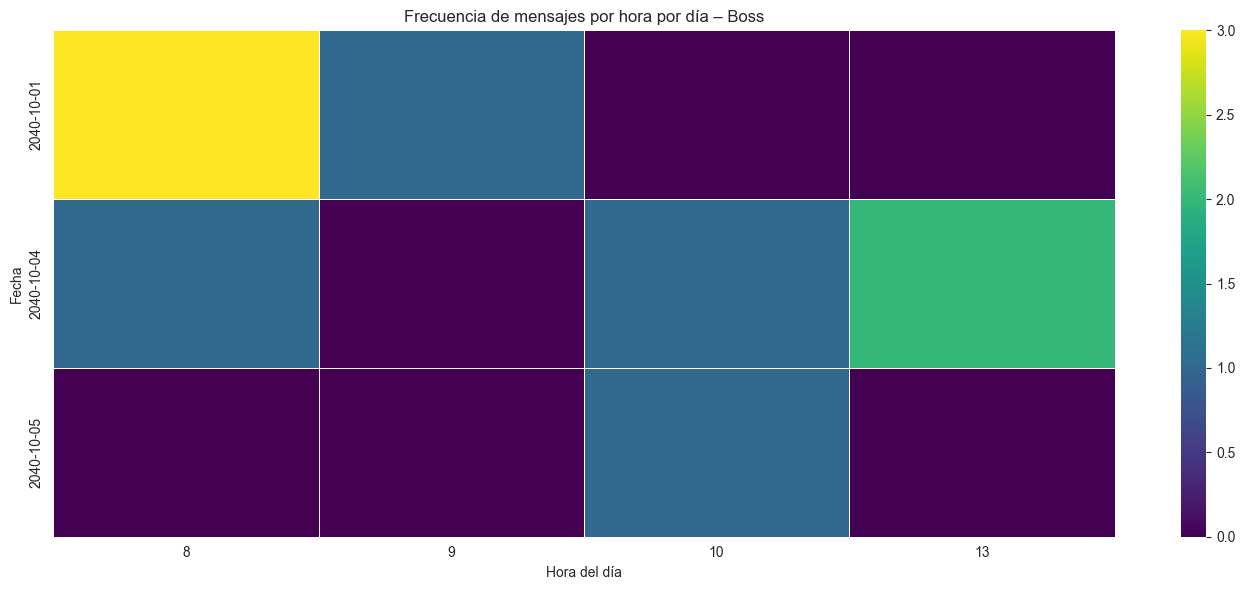

In [24]:
# Elegimos un sender (por ejemplo, el primero en la lista)
sender_to_plot = grouped['sender'].unique()[0]

filtered = grouped[grouped['sender'] == sender_to_plot]

# Creamos tabla con días como filas y horas como columnas
pivot = filtered.pivot_table(index='day', columns='hour', values='count', fill_value=0)

plt.figure(figsize=(14, 6))
sns.heatmap(pivot, cmap='viridis', linewidths=0.5)
plt.title(f'Frecuencia de mensajes por hora por día – {sender_to_plot}')
plt.xlabel('Hora del día')
plt.ylabel('Fecha')
plt.tight_layout()
plt.show()


In [31]:
df_stream = df_comm.groupby(['day', 'hour','sender']).size().reset_index(name='count')

In [26]:
df_comm

,sender,message_id,content,timestamp,receiver,day,hour
0,The Lookout,Event_Communication_1,"Hey The Intern, its The Lookout! Just spotted ...",2040-10-01 08:09:00,The Intern,2040-10-01,1970-01-01 00:00:00.000000008
1,The Intern,Event_Communication_2,"Hey The Lookout, The Intern here! Id absolutel...",2040-10-01 08:10:00,The Lookout,2040-10-01,1970-01-01 00:00:00.000000008
2,Kelly,Event_Communication_3,"Sam, its Kelly! Lets meet at Sunrise Point at ...",2040-10-01 08:13:00,Sam,2040-10-01,1970-01-01 00:00:00.000000008
3,The Intern,Event_Communication_5,"Mrs. Money, its The Intern. Just checking in t...",2040-10-01 08:16:00,Mrs. Money,2040-10-01,1970-01-01 00:00:00.000000008
4,Mrs. Money,Event_Communication_6,"Boss, its Mrs. Money. Ive reviewed our operati...",2040-10-01 08:19:00,Boss,2040-10-01,1970-01-01 00:00:00.000000008
...,...,...,...,...,...,...,...
579,Oceanus City Council,Event_Communication_994,"Green Guardians, Oceanus City Council here. Yo...",2040-10-14 12:50:00,Green Guardians,2040-10-14,1970-01-01 00:00:00.000000012
580,Green Guardians,Event_Communication_997,"EcoVigil, Green Guardians HQ here. Your video ...",2040-10-14 12:51:00,EcoVigil,2040-10-14,1970-01-01 00:00:00.000000012
581,Defender,Event_Communication_999,Defender to Mako. Be advised that conservation...,2040-10-14 13:31:00,Mako,2040-10-14,1970-01-01 00:00:00.000000013
582,Knowles,Event_Communication_1001,"Knowles, Mako here. Proceed to southern dock a...",2040-10-14 13:34:00,Davis,2040-10-14,1970-01-01 00:00:00.000000013


In [27]:
timeframe = df_comm.groupby(pd.Grouper(key='timestamp', freq='1h')).count() #Group by hour and sum values
#["timestamp"].dt.time
timeframe

,sender,message_id,content,receiver,day,hour
timestamp,,,,,,
2040-10-01 08:00:00,15,15,15,15,15,15
2040-10-01 09:00:00,6,6,6,6,6,6
2040-10-01 10:00:00,8,8,8,8,8,8
2040-10-01 11:00:00,7,7,7,7,7,7
2040-10-01 12:00:00,8,8,8,8,8,8
...,...,...,...,...,...,...
2040-10-14 09:00:00,7,7,7,7,7,7
2040-10-14 10:00:00,2,2,2,2,2,2
2040-10-14 11:00:00,5,5,5,5,5,5


In [33]:
pivot_df = df_stream.pivot(index='day', columns='sender', values='count').fillna(0)

# Ordenamos por volumen total
sender_totals = pivot_df.sum().sort_values(ascending=False)

# Widget para elegir cuántos senders mostrar
num_senders_widget = widgets.IntSlider(
    value=10,
    min=2,
    max=min(30, len(sender_totals)),
    step=2,
    description='Top Senders:',
    continuous_update=False
)

# Función para actualizar el gráfico
def update_plot(num_senders):
    top_senders = sender_totals.head(num_senders).index
    data = []
    for sender in top_senders:
        data.append(go.Scatter(
            x=pivot_df.index,
            y=pivot_df[sender],
            mode='lines',
            stackgroup='one',
            name=sender,
            hovertemplate=f'Sender: {sender}<br>Día: %{{x}}<br>Mensajes: %{{y}}<extra></extra>'
        ))

    fig = go.Figure(data=data)
    fig.update_layout(
        title='Streamgraph de interacciones por día (Top Senders)',
        xaxis_title='Día',
        yaxis_title='Cantidad de mensajes',
        height=500,
        width=1000,
        legend_title_text='Sender',
    )
    fig.show()

# Conectar el widget
widgets.interact(update_plot, num_senders=num_senders_widget)


ValueError: Index contains duplicate entries, cannot reshape

In [34]:
df_stream

,day,hour,sender,count
0,2040-10-01,1970-01-01 00:00:00.000000008,Boss,3
1,2040-10-01,1970-01-01 00:00:00.000000008,Himark Harbor,1
2,2040-10-01,1970-01-01 00:00:00.000000008,Kelly,1
3,2040-10-01,1970-01-01 00:00:00.000000008,Mako,1
4,2040-10-01,1970-01-01 00:00:00.000000008,Mrs. Money,2
...,...,...,...,...
381,2040-10-14,1970-01-01 00:00:00.000000012,Rodriguez,1
382,2040-10-14,1970-01-01 00:00:00.000000012,Small Fry,1
383,2040-10-14,1970-01-01 00:00:00.000000012,The Lookout,1
384,2040-10-14,1970-01-01 00:00:00.000000013,Defender,1


In [30]:
num_senders_widget = widgets.IntSlider(
    value=10,
    min=2,
    max=30,
    step=2,
    description='Top Senders:',
    continuous_update=False
)

# Widget: hora del día
hour_widget = widgets.IntSlider(
    value=8,
    min=0,
    max=23,
    step=1,
    description='Hora:',
    continuous_update=False
)

# Función para actualizar el gráfico
def update_plot(num_senders, hour):
    # Filtramos por la hora seleccionada
    df_hour = df_stream[df_stream['hour'] == hour]

    # Pivot y top senders
    pivot_df = df_hour.pivot(index='day', columns='sender', values='count').fillna(0)
    sender_totals = pivot_df.sum().sort_values(ascending=False)
    top_senders = sender_totals.head(num_senders).index

    # Construcción del gráfico
    data = []
    for sender in top_senders:
        data.append(go.Scatter(
            x=pivot_df.index,
            y=pivot_df[sender],
            mode='lines',
            stackgroup='one',
            name=sender,
            hovertemplate=f'Sender: {sender}<br>Día: %{{x}}<br>Mensajes: %{{y}}<extra></extra>'
        ))

    fig = go.Figure(data=data)
    fig.update_layout(
        title=f'Streamgraph de interacciones por día — {hour}:00 hs (Top {num_senders} Senders)',
        xaxis_title='Día',
        yaxis_title='Cantidad de mensajes',
        height=500,
        width=1000,
        legend_title_text='Sender',
    )
    fig.show()

# Mostrar los widgets y conectar
widgets.interact(update_plot, num_senders=num_senders_widget, hour=hour_widget)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Top Senders:', max=30, min=2, …

<function __main__.update_plot(num_senders, hour)>